In [1]:
# Department: ESTSOFT
# Class: AI Modelling
# Category: Deep Learing, Game
# Title: TellingByfAIce
# Contributors: Kimm Soo Min
# Last modified date: 21/06/25

In [1]:
# Library
import os
import json
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Path
data_path = "/workspace/data"

In [4]:
# Hyperparameters
label_map = {"anger": 0, "happy": 1, "panic": 2, "sadness": 3}
num_labels = len(label_map)
image_size = 224
batch_size = 32
epochs = 100

In [5]:
# Load json
def load_json(file):
	with open(file=file, mode='r', encoding='euc-kr') as f:
		return json.load(f)

In [6]:
# Dataset - Classifier
class ClassifierDataset(Dataset):
	def __init__(self, dir_root, set_name, label_map, transform=None):
		self.samples = []
		self.dir_root = dir_root
		self.set_name = set_name
		self.transform = transform
		self.label_map = label_map
		self.num_labels = len(label_map)

		# Set paths
		if set_name == "test":
			label_dir = os.path.join(dir_root, "test", "label")
			img_dir_root = os.path.join(dir_root, "test", "image")
		else:
			label_dir = os.path.join(dir_root, "train", "label", set_name)
			img_dir_root = os.path.join(dir_root, "train", "image", set_name)

		# Iterate through the directory to grab information about images
		label_paths = [os.path.join(label_dir, f) for f in os.listdir(label_dir)]
		for label_path in label_paths:
			label = os.path.basename(label_path).split("_")[-1].split(".")[0]  # "train_anger.json" -> "anger"
			img_dir = os.path.join(img_dir_root, label)

			data = load_json(label_path)
			for item in data:
				image_path = os.path.join(img_dir, item["filename"])

				# Check if the file actually exists
				if not os.path.exists(image_path):
					continue

				self.samples.append({"image_path": image_path,
									 "label": label,
									 "bbox": item["annot_A"]["boxes"]})

	def __len__(self):
		return len(self.samples)

	def __getitem__(self, idx):
		item = self.samples[idx]
		image = Image.open(item["image_path"]).convert("RGB")

		box = item["bbox"]
		X_min = int(box["minX"])
		Y_min = int(box["minY"])
		X_max = int(box["maxX"])
		Y_max = int(box["maxY"])

		# Crop face
		image = image.crop((X_min, Y_min, X_max, Y_max))
		image = self.transform(image)

		label = torch.zeros(self.num_labels, dtype=torch.float32)
		label[self.label_map[item["label"]]] = 1.0

		return image, label

In [7]:
# Transform
transform = transforms.Compose([transforms.Resize((image_size, image_size)),
								transforms.ToTensor(),
								transforms.Normalize(mean=(0.5, 0.5, 0.5),
							 						 std=(0.5, 0.5, 0.5))])

In [8]:
# Dataset
ds_train = ClassifierDataset(dir_root=data_path, set_name="train", label_map=label_map, transform=transform)
ds_val   = ClassifierDataset(dir_root=data_path, set_name="val", label_map=label_map, transform=transform)
ds_test  = ClassifierDataset(dir_root=data_path, set_name="test", label_map=label_map, transform=transform)


In [9]:
# Dataloader
dl_train = DataLoader(dataset=ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(dataset=ds_val, batch_size=batch_size, shuffle=False)
dl_test = DataLoader(dataset=ds_test, batch_size=batch_size, shuffle=False)

In [10]:
# ViT - Classifier
class vit_classifier(nn.Module):
	def __init__(self, num_classes=4):
		super().__init__()
		self.backbone = timm.create_model("vit_base_patch16_224", pretrained=True)
		self.num_features = self.backbone.head.in_features
		self.backbone.head = nn.Identity()
		self.fc_label = nn.Linear(self.num_features, num_classes)

	def forward(self, x):
		x = self.backbone(x)
		return self.fc_label(x)

In [ ]:
# Instantiation w/o fine-tuning
model_classifier = vit_classifier(num_classes=num_labels).to(device)
for param in model_classifier.backbone.parameters():
    param.requires_grad = False
optimizer_classifier = torch.optim.Adam(model_classifier.parameters(), lr=1e-5)
loss_classifier = nn.BCEWithLogitsLoss()

In [ ]:
# Early stopping
loss_val_best = float('inf')
patience = 5          
patience_counter = 0 

In [5]:
losses_train = []
losses_val = []
for epoch in tqdm(range(epochs)):
	# Training
	model_classifier.train()
	loss_train_total = 0
	for X_train, y_train in dl_train:
		X_train, y_train = X_train.to(device), y_train.to(device)

		y_train_pred = model_classifier(X_train)
		loss_train = loss_classifier(y_train_pred, y_train)

		optimizer_classifier.zero_grad()
		loss_train.backward()
		optimizer_classifier.step()

		loss_train_total += loss_train.item()
	
	losses_train.append(loss_train_total / len(dl_train))

	# Validation
	model_classifier.eval()
	loss_val_total = 0
	with torch.inference_mode():
		for X_val, y_val in dl_val:
			X_val, y_val = X_val.to(device), y_val.to(device)

			y_val_pred = model_classifier(X_val)
			loss_val = loss_classifier(y_val_pred, y_val)
			
			loss_val_total += loss_val.item()

		loss_val_avg = loss_val_total / len(dl_val)
		losses_val.append(loss_val_avg)

	print(f"Epoch {epoch + 1} | Train Loss: {loss_train_total / len(dl_train):.4f} | Val Loss: {loss_val_total / len(dl_val):.4f}")
	
	# Early stopping
	if loss_val_avg < loss_val_best:
		loss_val_best = loss_val_avg
		patience_counter = 0
		torch.save(model_classifier.state_dict(), f"/workspace/experiment/vit_classifier_wo_finetuning_best.pth")
	else:
		patience_counter += 1
		if patience_counter >= patience:
			print(f"Early stopping triggered at epoch {epoch + 1}")
			break

	# Save periodically
	if (epoch + 1) % 5 == 0:
		torch.save(model_classifier.state_dict(), f"/workspace/experiment/vit_classifier_wo_finetuning_epoch_{epoch+1}.pth")

NameError: name 'epochs' is not defined

In [ ]:
# Testing
model_classifier.eval()
y_preds = []
y_trues = []
losses_test = []
loss_test_total = 0
with torch.inference_mode():
	for X_test, y_test in dl_test:
		X_test, y_test = X_test.to(device), y_test.to(device)

		y_test_pred  = model_classifier(X_test)
		loss_test = loss_classifier(y_test_pred, y_test)

		loss_test_total += loss_test.item()
		
		y_pred = (torch.sigmoid(y_test_pred) > 0.5).int()
		
		y_preds.append(y_pred.cpu().numpy())
		y_trues.append(y_test.cpu().numpy())
		
	y_preds = np.concatenate(y_preds, axis=0)
	y_trues = np.concatenate(y_trues, axis=0)
		
	losses_test.append(loss_test_total / len(dl_test))
	
print(f"\nTest Loss: {loss_test_total / len(dl_test):.4f}")


Test Loss: 0.3930


              precision    recall  f1-score   support

       anger       0.81      0.64      0.72       300
       happy       0.92      0.93      0.93       275
       panic       0.78      0.83      0.81       300
     sadness       0.82      0.79      0.80       300

   micro avg       0.83      0.80      0.81      1175
   macro avg       0.83      0.80      0.81      1175
weighted avg       0.83      0.80      0.81      1175
 samples avg       0.79      0.80      0.79      1175



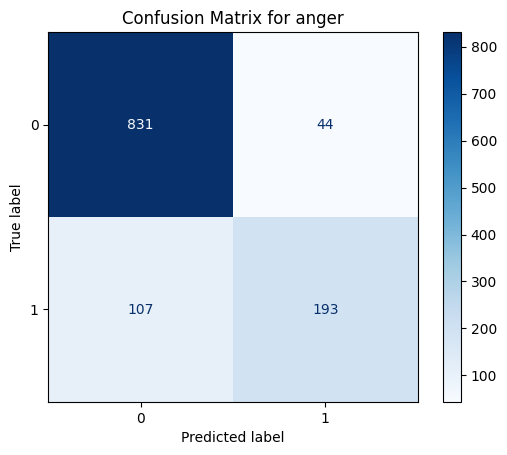

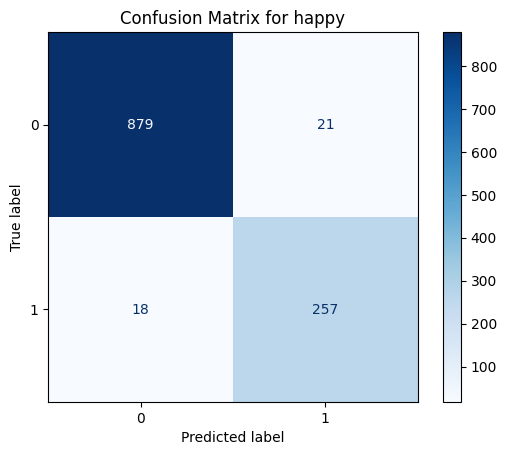

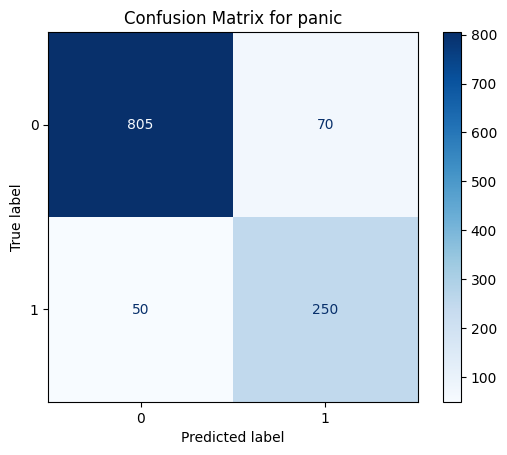

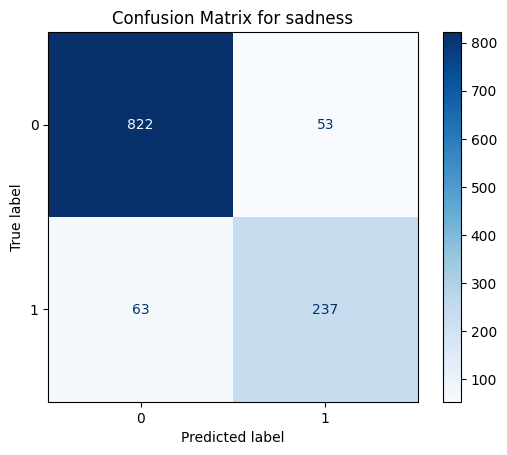

In [ ]:
# Evaluation
print(classification_report(y_trues, y_preds, target_names=list(label_map.keys()), zero_division=0))

for i in range(num_labels):
	cm = confusion_matrix(y_trues[:, i], y_preds[:, i])
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
	disp.plot(cmap=plt.cm.Blues)
	plt.title(f"Confusion Matrix for {list(label_map.keys())[i]}")
	plt.show()

In [ ]:
# Prediction
from PIL import Image, ImageDraw, ImageOps
from torchvision import transforms

model_path = "/workspace/experiment/vit_classifier_wo_finetuning_best.pth"
model_classifier = vit_classifier(num_classes=4).to(device)
model_classifier.load_state_dict(torch.load(model_path, map_location=device))
model_classifier.eval()

vit_classifier(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='n

In [ ]:
# Label map and reverse lookup
idx_to_label = {v: k for k, v in label_map.items()}

# Predict function
def predict_emotion(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.inference_mode():
        logits = model_classifier(image_tensor)
        pred_idx = torch.argmax(logits, dim=1).item()
        pred_label = idx_to_label[pred_idx]
    
    return pred_label

image_path = "/workspace/experiment/image_cropped.png"
predicted_emotion = predict_emotion(image_path)
print(f"Predicted Emotion: {predicted_emotion}")

Predicted Emotion: anger


In [11]:
# Instantiation w/ fine-tuning
model_classifier = vit_classifier(num_classes=num_labels).to(device)
for param in model_classifier.backbone.parameters():
    param.requires_grad = True
optimizer_classifier = torch.optim.Adam(model_classifier.parameters(), lr=1e-5)
loss_classifier = nn.BCEWithLogitsLoss()

In [12]:
# Early stopping
loss_val_best = float('inf')
patience = 5          
patience_counter = 0 

In [13]:
losses_train = []
losses_val = []
for epoch in tqdm(range(epochs)):
	# Training
	model_classifier.train()
	loss_train_total = 0
	for X_train, y_train in dl_train:
		X_train, y_train = X_train.to(device), y_train.to(device)

		y_train_pred = model_classifier(X_train)
		loss_train = loss_classifier(y_train_pred, y_train)

		optimizer_classifier.zero_grad()
		loss_train.backward()
		optimizer_classifier.step()

		loss_train_total += loss_train.item()
	
	losses_train.append(loss_train_total / len(dl_train))

	# Validation
	model_classifier.eval()
	loss_val_total = 0
	with torch.inference_mode():
		for X_val, y_val in dl_val:
			X_val, y_val = X_val.to(device), y_val.to(device)

			y_val_pred = model_classifier(X_val)
			loss_val = loss_classifier(y_val_pred, y_val)
			
			loss_val_total += loss_val.item()

		loss_val_avg = loss_val_total / len(dl_val)
		losses_val.append(loss_val_avg)

	print(f"Epoch {epoch + 1} | Train Loss: {loss_train_total / len(dl_train):.4f} | Val Loss: {loss_val_total / len(dl_val):.4f}")
	
	# Early stopping
	if loss_val_avg < loss_val_best:
		loss_val_best = loss_val_avg
		patience_counter = 0
		torch.save(model_classifier.state_dict(), f"/workspace/experiment/vit_classifier_w_finetuning_best.pth")
	else:
		patience_counter += 1
		if patience_counter >= patience:
			print(f"Early stopping triggered at epoch {epoch + 1}")
			break

	# Save periodically
	if (epoch + 1) % 5 == 0:
		torch.save(model_classifier.state_dict(), f"/workspace/experiment/vit_classifier_w_finetuning_epoch_{epoch+1}.pth")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.2954 | Val Loss: 0.2387


  1%|          | 1/100 [22:58<37:53:47, 1378.06s/it]

Epoch 2 | Train Loss: 0.1443 | Val Loss: 0.2225


  3%|▎         | 3/100 [1:10:27<38:11:37, 1417.50s/it]

Epoch 3 | Train Loss: 0.0736 | Val Loss: 0.2631


  4%|▍         | 4/100 [1:34:21<37:58:48, 1424.25s/it]

Epoch 4 | Train Loss: 0.0323 | Val Loss: 0.3106
Epoch 5 | Train Loss: 0.0209 | Val Loss: 0.3808


  6%|▌         | 6/100 [2:22:46<37:37:42, 1441.09s/it]

Epoch 6 | Train Loss: 0.0124 | Val Loss: 0.4059


  6%|▌         | 6/100 [2:46:52<43:34:20, 1668.73s/it]

Epoch 7 | Train Loss: 0.0075 | Val Loss: 0.3930
Early stopping triggered at epoch 7


In [14]:
# Testing
model_classifier.eval()
y_preds = []
y_trues = []
losses_test = []
loss_test_total = 0
with torch.inference_mode():
	for X_test, y_test in dl_test:
		X_test, y_test = X_test.to(device), y_test.to(device)

		y_test_pred  = model_classifier(X_test)
		loss_test = loss_classifier(y_test_pred, y_test)

		loss_test_total += loss_test.item()
		
		y_pred = (torch.sigmoid(y_test_pred) > 0.5).int()
		
		y_preds.append(y_pred.cpu().numpy())
		y_trues.append(y_test.cpu().numpy())
		
	y_preds = np.concatenate(y_preds, axis=0)
	y_trues = np.concatenate(y_trues, axis=0)
		
	losses_test.append(loss_test_total / len(dl_test))
	
print(f"\nTest Loss: {loss_test_total / len(dl_test):.4f}")


Test Loss: 0.4254


              precision    recall  f1-score   support

       anger       0.83      0.62      0.71       300
       happy       0.90      0.95      0.93       275
       panic       0.81      0.83      0.82       300
     sadness       0.79      0.85      0.82       300

   micro avg       0.83      0.81      0.82      1175
   macro avg       0.84      0.81      0.82      1175
weighted avg       0.83      0.81      0.82      1175
 samples avg       0.81      0.81      0.81      1175



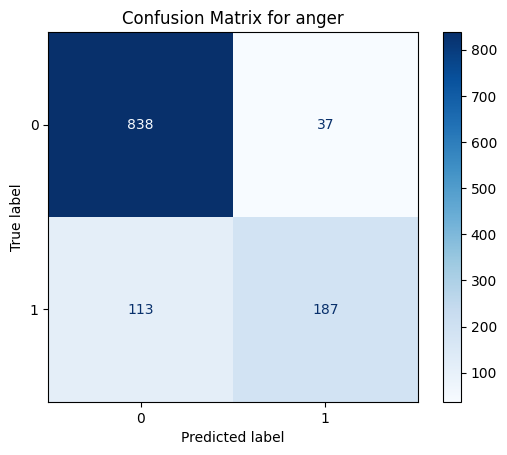

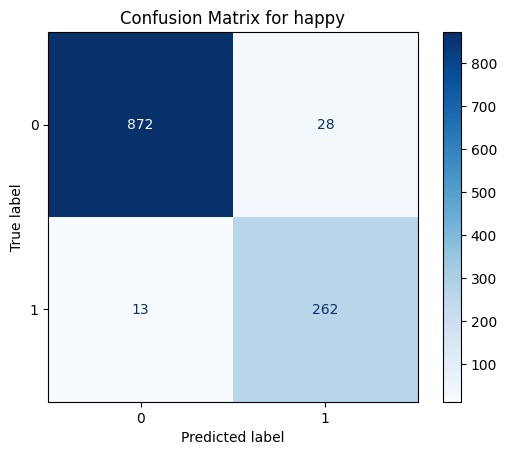

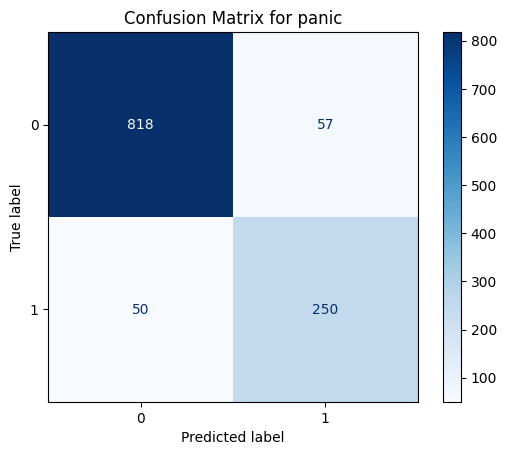

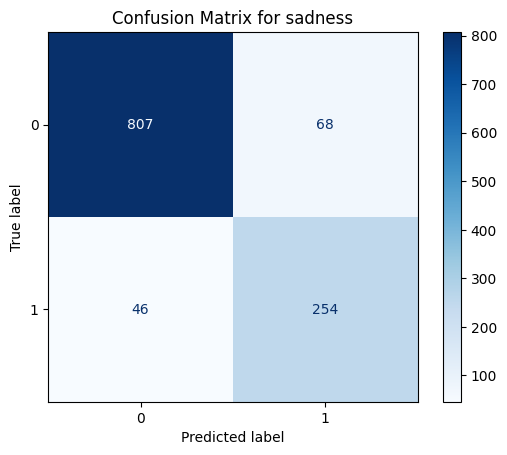

In [15]:
# Evaluation
print(classification_report(y_trues, y_preds, target_names=list(label_map.keys()), zero_division=0))

for i in range(num_labels):
	cm = confusion_matrix(y_trues[:, i], y_preds[:, i])
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
	disp.plot(cmap=plt.cm.Blues)
	plt.title(f"Confusion Matrix for {list(label_map.keys())[i]}")
	plt.show()

In [16]:
# Prediction
from PIL import Image, ImageDraw, ImageOps
from torchvision import transforms

model_path = "/workspace/experiment/vit_classifier_w_finetuning_best.pth"
model_classifier = vit_classifier(num_classes=4).to(device)
model_classifier.load_state_dict(torch.load(model_path, map_location=device))
model_classifier.eval()

vit_classifier(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='n

In [17]:
# Label map and reverse lookup
idx_to_label = {v: k for k, v in label_map.items()}

# Predict function
def predict_emotion(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.inference_mode():
        logits = model_classifier(image_tensor)
        pred_idx = torch.argmax(logits, dim=1).item()
        pred_label = idx_to_label[pred_idx]
    
    return pred_label

image_path = "/workspace/experiment/image_cropped.png"
predicted_emotion = predict_emotion(image_path)
print(f"Predicted Emotion: {predicted_emotion}")

Predicted Emotion: happy
